<a href="https://colab.research.google.com/github/arpan-das-astrophysics/LangChain-Vector-Databases-in-Production-Activeloop/blob/main/Exploring_The_Role_of_LangChain's_Indexes_and_Retrievers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Exploring The Role of LangChain's Indexes and Retrievers**

## **Introduction**
In LangChain, indexes and retrievers play a crucial role in structuring documents and fetching relevant data for LLMs.  We will explore some of the advantages and disadvantages of using document based LLMs (i.e., LLMs that leverage relevant pieces of documents inside their prompts), with a particular focus on the role of indexes and retrievers.

An index is a powerful data structure that meticulously organizes and stores documents to enable efficient searching, while a retriever harnesses the index to locate and return pertinent documents in response to user queries. Within LangChain, the primary index types are centered on vector databases, with embeddings-based indexes being the most prevalent.

Retrievers focus on extracting relevant documents to merge with prompts for language models. A retriever exposes a get_relevant_documents method, which accepts a query string as input and returns a list of related documents.

In [ ]:
!pip install langchain==0.0.208 deeplake openai tiktoken

In [2]:
from getpass import getpass
import os
os.environ["OPENAI_API_KEY"] = getpass()

··········


In [3]:
from langchain.document_loaders import TextLoader

# text to write to a local file
# taken from https://www.theverge.com/2023/3/14/23639313/google-ai-language-model-palm-api-challenge-openai
text = """Google opens up its AI language model PaLM to challenge OpenAI and GPT-3
Google is offering developers access to one of its most advanced AI language models: PaLM.
The search giant is launching an API for PaLM alongside a number of AI enterprise tools
it says will help businesses “generate text, images, code, videos, audio, and more from
simple natural language prompts.”

PaLM is a large language model, or LLM, similar to the GPT series created by OpenAI or
Meta’s LLaMA family of models. Google first announced PaLM in April 2022. Like other LLMs,
PaLM is a flexible system that can potentially carry out all sorts of text generation and
editing tasks. You could train PaLM to be a conversational chatbot like ChatGPT, for
example, or you could use it for tasks like summarizing text or even writing code.
(It’s similar to features Google also announced today for its Workspace apps like Google
Docs and Gmail.)
"""

# write text to local file
with open("my_file.txt", "w") as file:
    file.write(text)

# use TextLoader to load text from local file
loader = TextLoader("my_file.txt")
docs_from_file = loader.load()

print(len(docs_from_file))
# 1

1


Then, we use CharacterTextSplitter to split the docs into texts.

In [4]:
from langchain.text_splitter import CharacterTextSplitter

# create a text splitter
text_splitter = CharacterTextSplitter(chunk_size=200, chunk_overlap=20)

# split documents into chunks
docs = text_splitter.split_documents(docs_from_file)

print(len(docs))
# 2

2


These embeddings allow us to effectively search for documents or portions of documents that relate to our query by examining their semantic similarities.

In [5]:
from langchain.embeddings import OpenAIEmbeddings

# Before executing the following code, make sure to have
# your OpenAI key saved in the “OPENAI_API_KEY” environment variable.
embeddings = OpenAIEmbeddings(model="text-embedding-ada-002")

We'll employ the Deep Lake vector store with our embeddings in place.

Deep Lake provides several advantages over the typical vector store:

* It’s multimodal, which means that it can be used to store items of diverse modalities, such as texts, images, audio, and video, along with their vector representations.
* It’s serverless, which means that we can create and manage cloud datasets without the need to create and managing a database instance. This aspect gives a great speedup to new projects.
* It’s possible to easily create a streaming data loader out of the data loaded into a Deep Lake dataset, which is convenient for fine-tuning machine learning models using common frameworks like PyTorch and TensorFlow.
* Data can be queried and visualized easily from the web.

Thanks to its nature, Deep Lake is well suited for being the serverless memory that LLM chains and agents need for several tasks, like storing relevant documents for question-answering or storing images to control some guided image-generation tasks. Here’s a diagram that visually summarizes this aspect.

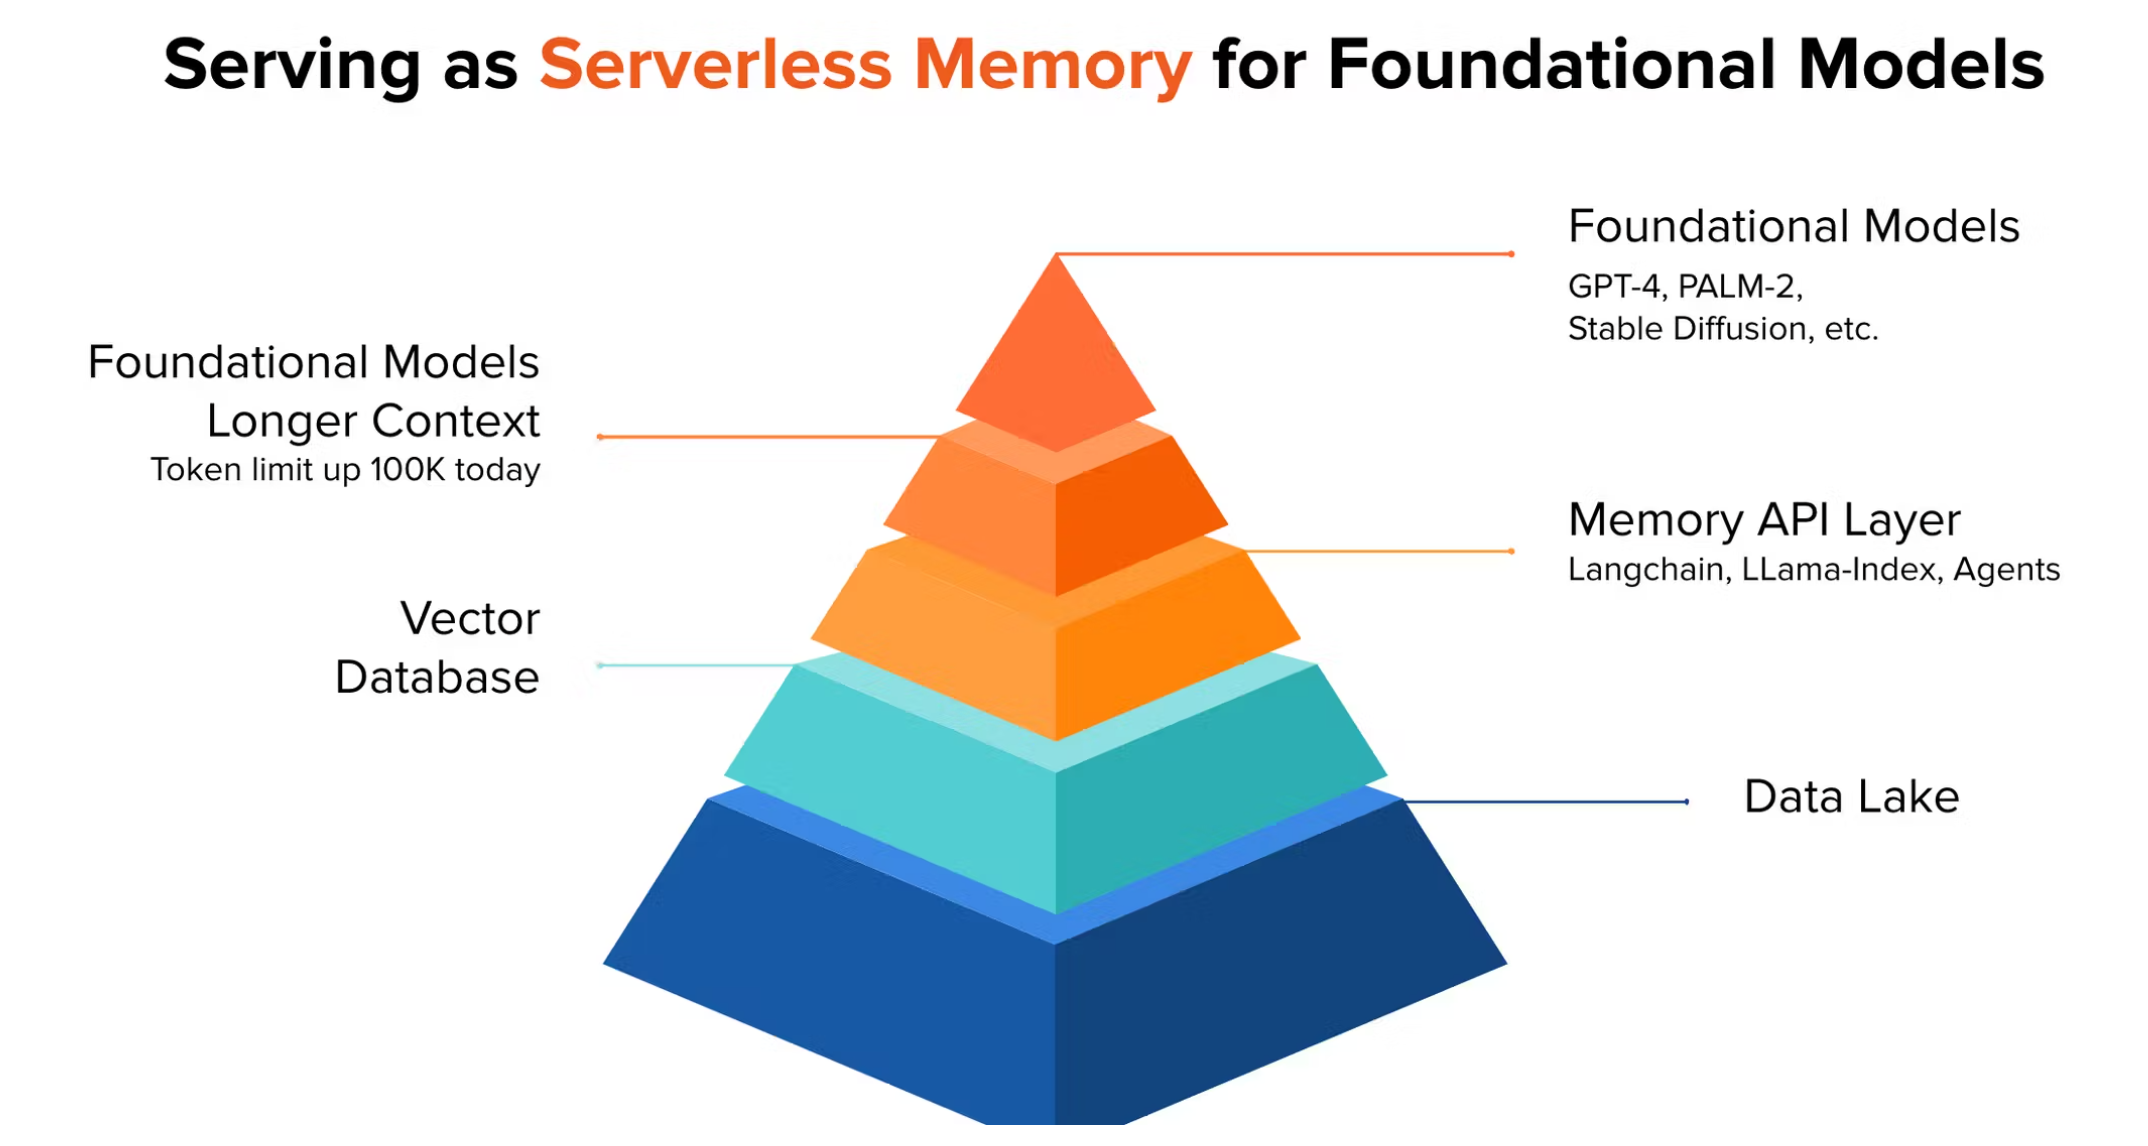

Let’s create an instance of a Deep Lake dataset.

In [6]:
from getpass import getpass
import os
os.environ["ACTIVELOOP_TOKEN"] = getpass()


··········


In [7]:
from langchain.vectorstores import DeepLake

# Before executing the following code, make sure to have your
# Activeloop key saved in the “ACTIVELOOP_TOKEN” environment variable.

# create Deep Lake dataset
# TODO: use your organization id here. (by default, org id is your username)
my_activeloop_org_id = "dasarpan007"
my_activeloop_dataset_name = "langchain_course_indexers_retrievers"
dataset_path = f"hub://{my_activeloop_org_id}/{my_activeloop_dataset_name}"
db = DeepLake(dataset_path=dataset_path, embedding_function=embeddings)

# add documents to our Deep Lake dataset
db.add_documents(docs)

Your Deep Lake dataset has been successfully created!


-

Dataset(path='hub://dasarpan007/langchain_course_indexers_retrievers', tensors=['embedding', 'id', 'metadata', 'text'])

  tensor      htype      shape     dtype  compression
  -------    -------    -------   -------  ------- 
 embedding  embedding  (2, 1536)  float32   None   
    id        text      (2, 1)      str     None   
 metadata     json      (2, 1)      str     None   
   text       text      (2, 1)      str     None   


['81b1bb0a-2885-11ee-9c95-0242ac1c000c',
 '81b1bcfe-2885-11ee-9c95-0242ac1c000c']

In this example, we are adding text documents to the dataset. However, being Deep Lake multimodal, we could have also added images to it, specifying an image embedder model. This could be useful for searching images according to a text query or using an image as a query (and thus looking for similar images).

As datasets become bigger, storing them in local memory becomes less manageable. In this example, we could have also used a local vector store, as we are uploading only two documents. However, in a typical production scenario, thousands or millions of documents could be used and accessed from different programs, thus having the need for a centralized cloud dataset.

Back to the code example of this lesson. Next, we create a retriever.

In [8]:
# create retriever from db
retriever = db.as_retriever()

Once we have the retriever, we can start with question-answering.

In [9]:
from langchain.chains import RetrievalQA
from langchain.llms import OpenAI

# create a retrieval chain
qa_chain = RetrievalQA.from_chain_type(
	llm=OpenAI(model="text-davinci-003"),
	chain_type="stuff",
	retriever=retriever
)

We can query our document that is an about specific topic that can be found in the documents.

In [10]:
query = "How Google plans to challenge OpenAI?"
response = qa_chain.run(query)
print(response)

 Google is offering developers access to its AI language model PaLM, which is similar to the GPT series created by OpenAI, and launching an API and AI enterprise tools that can generate text, images, code, videos, audio, and more from simple natural language prompts.


## **What occurred behind the scenes?**
Initially, we employed a so-called "stuff chain" (refer to CombineDocuments Chains). Stuffing is one way to supply information to the LLM. Using this technique, we "stuff" all the information into the LLM's prompt. However, this method is only effective with shorter documents, as most LLMs have a context length limit.

Additionally, a similarity search is conducted using the embeddings to identify matching documents to be used as context for the LLM. Although it might not seem particularly useful with just one document, we are effectively working with multiple documents since we "chunked" our text. Preselecting the most suitable documents based on semantic similarity enables us to provide the model with meaningful knowledge through the prompt while remaining within the allowed context size.

So, in this exploration, we have discovered the significant role that indexes and retrievers play in improving the performance of Large Language Models when handling document-based data.

The system becomes more efficient in finding and presenting relevant information by converting documents and user queries into numerical vectors (embeddings) and storing them in specialized databases like Deep Lake, which serves as our vector store database.

The retriever's ability to identify documents that are closely related to a user's query in the embedding space demonstrates the effectiveness of this approach in enhancing the overall language understanding capabilities of LLMs.

### **A Potential Problem**
This method has a downside: you might not know how to get the right documents later when storing data. In the Q&A example, we cut the text into equal parts, causing both useful and useless text to show up when a user asks a question.

Including unrelated information in the LLM prompt is detrimental because:

1. It can divert the LLM's focus from pertinent details.
2. It occupies valuable space that could be utilized for more relevant information.

### **Possible Solution**
A `DocumentCompressor` abstraction has been introduced to address this issue, allowing compress_documents on the retrieved documents.

The `ContextualCompressionRetriever` is a wrapper around another retriever in LangChain. It takes a base retriever and a `DocumentCompressor` and automatically compresses the retrieved documents from the base retriever. This means that only the most relevant parts of the retrieved documents are returned, given a specific query.

A popular compressor choice is the `LLMChainExtractor`, which uses an LLMChain to extract only the statements relevant to the query from the documents. To improve the retrieval process, a `ContextualCompressionRetriever` is used, wrapping the base retriever with an `LLMChainExtractor`. The `LLMChainExtractor` iterates over the initially returned documents and extracts only the content relevant to the query.

Here's an example of how to use `ContextualCompressionRetriever` with `LLMChainExtractor`:

In [11]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor

# create GPT3 wrapper
llm = OpenAI(model="text-davinci-003", temperature=0)

# create compressor for the retriever
compressor = LLMChainExtractor.from_llm(llm)
compression_retriever = ContextualCompressionRetriever(
	base_compressor=compressor,
	base_retriever=retriever
)

Once we have created the `compression_retriever`, we can use it to retrieve the compressed relevant documents to a query.

In [12]:
# retrieving compressed documents
retrieved_docs = compression_retriever.get_relevant_documents(
	"How Google plans to challenge OpenAI?"
)
print(retrieved_docs[0].page_content)

/usr/local/lib/python3.10/dist-packages/langchain/chains/llm.py:275: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


Google is offering developers access to one of its most advanced AI language models: PaLM. The search giant is launching an API for PaLM alongside a number of AI enterprise tools it says will help businesses “generate text, images, code, videos, audio, and more from simple natural language prompts.”


Compressors aim to make it easy to pass only the relevant information to the LLM. Doing this also enables you to pass along more information to the LLM since in the initial retrieval step, you can focus on recall (e.g., by increasing the number of documents returned) and let the compressors handle precision:

## **Conclusion**
In summary, LangChain's indexes and retrievers offer modular, flexible, and customizable solutions for working with unstructured data and language models. However, they have limited support for structured data and are mainly focused on vector databases.

In the next lesson, we’ll see some convenient LangChain classes for loading data from different sources, that is data loaders.